<a href="https://colab.research.google.com/github/nguyen-nhat-mai/object_detection/blob/main/Rotate_img_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotating image & box in YOLO format

In [ ]:
# Set up
import cv2
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal
import random
from google.colab import drive

In [ ]:
# Mounting the Google Drive to the Colab notebook, force_remount = True to ensure that the drive is remounted even if it was previously mounted
drive.mount('/content/gdrive',force_remount=True) 
!pwd # print the current working directory

Mounted at /content/gdrive
/content


## Define function to rotate image & box in YOLO format

*Reference*

Usman Rafique, "Rotating Bounding Boxes for Object Detection Using YOLO", URML Blog, Mar. 05, 2020. 

Available: https://usmanr149.github.io/urmlblog/yolo/2020/03/05/rotate_yolo_bbox.html.

In [ ]:
def yoloFormattocv(x1, y1, x2, y2, H, W):
    '''
    The purpose of this function is to convert object bounding box coordinates in the YOLO format to the OpenCV format. The input parameters are:
    x1: the x-coordinate of the top-left corner of the bounding box in the YOLO format
    y1: the y-coordinate of the top-left corner of the bounding box in the YOLO format
    x2: the x-coordinate of the bottom-right corner of the bounding box in the YOLO format
    y2: the y-coordinate of the bottom-right corner of the bounding box in the YOLO format
    H: the height of the image
    W: the width of the image
    The output of the function is a list of four integer values representing the bounding box coordinates in the OpenCV format: [x_min, y_min, x_max, y_max].
    '''
    # Convert the normalized YOLO bbox width and height to absolute values in pixels
    bbox_width = x2 * W
    bbox_height = y2 * H
    # Calculate the absolute pixel location of the center of the bbox
    center_x = x1 * W
    center_y = y1 * H
    # Convert the YOLO bbox coordinates to OpenCV format (left, top, right, bottom)
    cv = []
    cv.append(center_x - (bbox_width / 2))
    cv.append(center_y - (bbox_height / 2))
    cv.append(center_x + (bbox_width / 2))
    cv.append(center_y + (bbox_height / 2))
    # Return the OpenCV format bounding box coordinates as a list of integers
    return [int(v) for v in cv]

In [ ]:
def cvFormattoYolo(corner, H, W):
    '''
    This function takes in a list of coordinates in cv format, and the height and width of an image:
    - corner: a list of coordinates in cv format, in the format ['label', 'x1', 'y1', 'x2', 'y2'].
    - H: the height of the image.
    - W: the width of the image.
    It returns a string of coordinates in YOLO format, in the format 'label x_center y_center box_width box_height'.
    '''
    # Extract width and height of the bounding box
    bbox_W = corner[3] - corner[1]
    bbox_H = corner[4] - corner[2]
    # Calculate center coordinates of the bounding box
    center_bbox_x = (corner[1] + corner[3]) / 2
    center_bbox_y = (corner[2] + corner[4]) / 2
    # Convert the coordinates to YOLO format and return them
    return corner[0]+' '+str(round(center_bbox_x / W, 6))+' '+str(round(center_bbox_y / H, 6))+' '+str(round(bbox_W / W, 6))+' '+str(round(bbox_H / H, 6))

In [ ]:
class yoloRotatebbox:
    def __init__(self, img_folder_path, box_folder_path,filename, image_ext, angle):
        '''
        The method initializes the object with these parameters and sets instance variables based on them. The method also performs some error checking by ensuring that the image file and box file exist.
        Parameters:
        - img_folder_path (str): The path to the folder where the image file is stored.
        - box_folder_path (str): The path to the folder where the box file is stored.
        - filename (str): The name of the file without the extension.
        - image_ext (str): The extension of the image file.
        - angle (float): The angle (in degrees) by which the image needs to be rotated.
        Returns:
        - None
        Raises:
        - AssertionError: If the image file or box file does not exist.
        '''
        # Check if the image and box files exist
        assert os.path.isfile(img_folder_path + "/" + filename + image_ext)
        assert os.path.isfile(box_folder_path + "/" + filename + '.txt')
        # Sets the instance variables
        self.img_folder_path = img_folder_path
        self.box_folder_path = box_folder_path
        self.filename = filename
        self.image_ext = image_ext
        self.angle = angle
        # Read image using cv2
        self.image = cv2.imread(self.img_folder_path + "/" + self.filename + self.image_ext, 1)
        # create a 2D-rotation matrix
        rotation_angle = self.angle * np.pi / 180
        self.rot_matrix = np.array(
            [[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
    def rotate_image(self):
        '''
        The rotate_image method rotates an image by the specified angle in degrees while expanding the image to avoid cropping
        Returns: 
        - rotated_mat (numpy.ndarray): The rotated image as a numpy array.
        '''
        # retrieves the height and width dimensions of the image stored in the instance variable self.image (noted that image shape has 3 dimensions)
        height, width = self.image.shape[:2]
        # prepare input for getRotationMatrix2D (coordinates in reverse order (width, height) compared to shape)
        image_center = (width / 2,
                        height / 2)  
        # create a rotation matrix based on the image center and the specified angle
        rotation_mat = cv2.getRotationMatrix2D(image_center, self.angle, 1.)
        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0, 0])
        abs_sin = abs(rotation_mat[0, 1])
        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)
        # subtract old image center (bringing image back to origin) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w / 2 - image_center[0]
        rotation_mat[1, 2] += bound_h / 2 - image_center[1]
        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(self.image, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def rotateYolobbox(self):
        '''
        This function is used to rotate bounding boxes of an image in YOLO format. 
        It takes no input parameters but uses the image and its associated bounding boxes that are previously loaded using the constructor.
        It returns the new bounding box coordinates in YOLO format
        '''
        # Get new height and width after rotating image
        new_height, new_width = self.rotate_image().shape[:2]
        # Open the file containing YOLO formatted bounding boxes for the original image
        f = open(self.box_folder_path + "/" + self.filename + '.txt', 'r')
        f1 = f.readlines()
        # Create an empty list to store YOLO formatted bounding boxes for the rotated image
        yolo_bbox = []
        # Get height and width of the original image
        H, W = self.image.shape[:2]
        # Loop over all bounding boxes in the file
        for x in f1:
            # Split the line into individual values for center x, center y, width, and height of the bounding box
            bbox = x.strip('\n').split(' ')
            # If the bounding box has more than one value (i.e. it is not an empty line)
            if len(bbox) > 1:
                # Convert the YOLO formatted bounding box coordinates to OpenCV format
                (center_x, center_y, bbox_width, bbox_height) = yoloFormattocv(float(bbox[1]), float(bbox[2]),
                                                                               float(bbox[3]), float(bbox[4]), H, W)
                
                # Shift the origin of the bounding box coordinates to the center of the image
                upper_left_corner_shift = (center_x - W / 2, -H / 2 + center_y)
                upper_right_corner_shift = (bbox_width - W / 2, -H / 2 + center_y)
                lower_left_corner_shift = (center_x - W / 2, -H / 2 + bbox_height)
                lower_right_corner_shift = (bbox_width - W / 2, -H / 2 + bbox_height)
                # Create a new empty lower right corner for the rotated bounding box
                new_lower_right_corner = [-1, -1]
                # Create a new empty upper left corner for the rotated bounding box
                new_upper_left_corner = []
                # Loop over the shifted corners of the bounding box
                for i in (upper_left_corner_shift, upper_right_corner_shift, lower_left_corner_shift,
                          lower_right_corner_shift):
                    # Rotate the shifted corner coordinates using the rotation matrix
                    new_coords = np.matmul(self.rot_matrix, np.array((i[0], -i[1])))
                    # Calculate the new coordinates of the rotated corner
                    x_prime, y_prime = new_width / 2 + new_coords[0], new_height / 2 - new_coords[1]
                    # Update the lower right corner of the rotated bounding box
                    if new_lower_right_corner[0] < x_prime:
                        new_lower_right_corner[0] = x_prime
                    if new_lower_right_corner[1] < y_prime:
                        new_lower_right_corner[1] = y_prime
                    # Update the upper left corner of the rotated bounding box
                    if len(new_upper_left_corner) > 0:
                        if new_upper_left_corner[0] > x_prime:
                            new_upper_left_corner[0] = x_prime
                        if new_upper_left_corner[1] > y_prime:
                            new_upper_left_corner[1] = y_prime
                    else:
                        new_upper_left_corner.append(x_prime)
                        new_upper_left_corner.append(y_prime)
                # Convert the rotated bounding box coordinates from OpenCV format to YOLO format and add to the list
                cv_bbox = [bbox[0], new_upper_left_corner[0], new_upper_left_corner[1],
                                 new_lower_right_corner[0], new_lower_right_corner[1]]
                yolo_bbox.append(cvFormattoYolo(cv_bbox,new_height,new_width))
        return yolo_bbox

## Test the function

In [ ]:
# Define a dictionary of colors to represent each class
box_color = {0:'blue',1:'orange',2:'green',3:'purple',4:'brown',5:'pink',
             6:'gray',7:'olive',8:'cyan',9:'gold',10:'turquoise',11:'navy',12:'yellow',13:'red'}

# Define a dictionary of names for each class
box_name = {0:'RazorBlade',1:'SafetyPin',2:'PaperClip',3:'Pen',4:'ThinNail',5:'Screw',
            6:'HandGun',7:'VgaConnector',8:'Knife',9:'MultiPurposeKnife',10:'Key',11:'Plier',12:'Shuriken',13:'Scissor'}

def plot_box(box_yolo_coordinates, height, width):
  '''
  This function plots bounding boxes on an image using YOLO coordinates. The function takes three arguments:
  - box_yolo_coordinates: a list of strings, where each string is a space-separated line of YOLO-formatted bounding box coordinates. The first element of each line is the class ID, followed by the box's normalized center coordinates (x, y) and its normalized width and height (w, h).
  - height: the height of the image in pixels.
  - width: the width of the image in pixels.
  '''
  # Iterate through each box in box_yolo_coordinates
  for row in box_yolo_coordinates:
    bbox = row.strip('\n').split(' ')
    # Convert YOLO coordinates to OpenCV coordinates using the yoloFormattocv() function
    [x1,y1,x2,y2] = yoloFormattocv(Decimal(bbox[1]),Decimal(bbox[2]),Decimal(bbox[3]),Decimal(bbox[4]),height, width)
    # Add a rectangle for each box
    plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=box_color[int(bbox[0])], facecolor='none', lw=1))
    # Add a label for each box at the center of the box
    plt.annotate(box_name[int(bbox[0])], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[int(bbox[0])], weight='bold', fontsize=10, ha='center', va='center')

['0 0.315484 0.579839 0.215269 0.220968\n',
 '3 0.683235 0.352419 0.176828 0.559677\n',
 '3 0.544848 0.568548 0.427975 0.688710\n',
 '3 0.309077 0.577419 0.207581 0.709677\n',
 '2 0.840842 0.190323 0.076882 0.174194\n',
 '2 0.318047 0.743548 0.292151 0.116129']

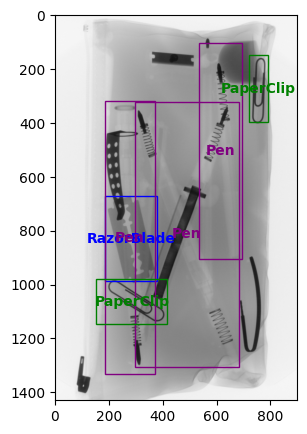

In [ ]:
'''Plot original image and its box'''

# Set the path of the image folder
img_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/images"
# Set the path of the image folder
image_name = 'B0002_0001'
image_ext = '.png'
# Read the image from the given path and name
image = cv2.imread(img_folder_path + "/" + image_name + image_ext)
# Set the figure size of the plot and display the image
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image)
# Set the path of the folder containing the bounding box labels for the image
box_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/labels"
# Get the height and width of the image
height, width,_ = image.shape
# Open the file containing the bounding box labels
f = open(box_folder_path+"/"+image_name + '.txt', 'r')
# Read the lines of the file
box_list = f.readlines()
# Call the plot_box() function to plot the bounding boxes on the image
plot_box(box_list, height, width)
# Return the list of bounding boxes
box_list

['0 0.57972 0.685 0.220979 0.214444',
 '3 0.352098 0.317222 0.56014 0.176667',
 '3 0.568182 0.456111 0.688811 0.427778',
 '3 0.577273 0.691667 0.70979 0.207778',
 '2 0.18986 0.159444 0.174126 0.076667',
 '2 0.743357 0.682778 0.116084 0.292222']

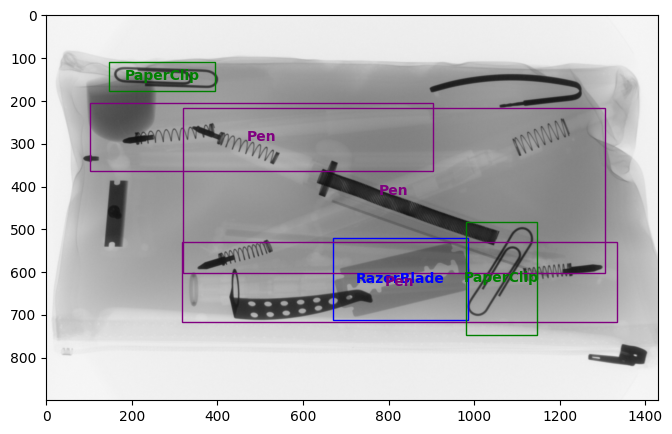

In [ ]:
'''Plot image rotated by 90 degree and its box'''

# Create an instance of the yoloRotatebbox class
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 90)
# Call the rotate_image() method of the im object to rotate the image by 90 degree
image_90 = im.rotate_image()
# Call the rotateYolobbox() method of the im object to rotate the YOLO format bounding boxes by the same angle
bbox_90 = im.rotateYolobbox()
# Extract the height and width of channels of the rotated image
(height, width,_) = image_90.shape
# Set the figure size of the plot and display the image
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image_90)
# Call the plot_box() function to plot the bounding boxes on the image
plot_box(bbox_90, height, width)
# Return the list of bounding boxes
bbox_90

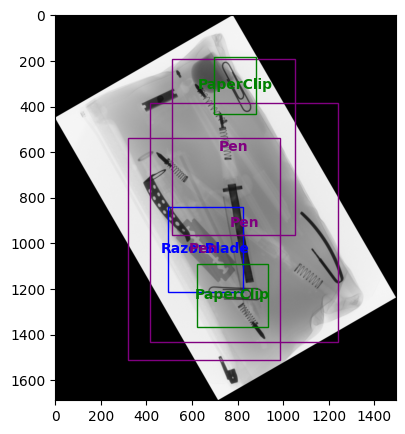

In [ ]:
'''Plot image rotated by 30 degree and its box'''

# Create an instance of the yoloRotatebbox class
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 30)
# Call the rotate_image() method of the im object to rotate the image by 30 degree
image_30 = im.rotate_image()
# Call the rotateYolobbox() method of the im object to rotate the YOLO format bounding boxes by the same angle
bbox_30 = im.rotateYolobbox()
# Extract the height and width of channels of the rotated image
(height, width,_) = image_30.shape
# Set the figure size of the plot and display the image
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image_30)
# Call the plot_box() function to plot the bounding boxes on the image
plot_box(bbox_30, height, width)

## Generate rotated images from existing images

In [ ]:
def generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, from_degree, to_degree):
  '''
  This function takes in input arguments image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, from_degree, and to_degree. 
  The function reads all the images in the image_folder_path directory and rotates each image and its corresponding bounding box in yolo format by a random degree in the range [from_degree, to_degree]. 
  Then it saves the rotated images and bounding boxes to the designated directories save_img_pth and save_annotation_path, respectively.
  Input:
  - image_folder_path: path to the directory containing original images
  - annotation_folder_path: path to the directory containing annotation files in YOLO format
  - save_img_pth: path to the directory where rotated images will be saved
  - save_annotation_path: path to the directory where rotated annotations will be saved
  - from_degree: minimum degree of rotation (inclusive)
  - to_degree: maximum degree of rotation (inclusive)
  Output: None but the function prints out the number of rotated images and bounding boxes that were saved.
  '''
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]
  # Loop through each image
  count = 0
  for img in image_list:
    try:
      count = count + 1
      # Rotate image & box in yolo format
      name = img.split(".")[0]
      degree = random.randint(from_degree,to_degree)
      rotate = yoloRotatebbox(image_folder_path, annotation_folder_path, name, ".png", degree)
      rotate_img = rotate.rotate_image()
      rotate_box = rotate.rotateYolobbox()
      # Save image and box into destination folders
      cv2.imwrite(save_img_pth + "/" + 'rotated_' + name +'_' + str(degree) + '.png', rotate_img)
      file_name = save_annotation_path + "/" +'rotated_'+ name +'_' + str(degree) + '.txt'
      # Write rotated box coordinates to annotation file
      with open(file_name, 'w') as fp:
        for i in range(len(rotate_box)):
          if i < (len(rotate_box)-1):
            fp.write(rotate_box[i]+"\n") # add break line for items not the last one
          else:
            fp.write(rotate_box[i]) # no break line for last item (avoid empty row)
    except:
      count = count - 1
      pass # some images do not have dangerous objects => no annotation file
  print("Rotated",count,"images/ boxes at random degree in range [",from_degree,",",to_degree,"]")

In [ ]:
# Get the folders
image_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/images"
annotation_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/labels"
save_img_pth = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/images"
save_annotation_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/labels"

In [ ]:
# Check consistency of images & box
image_list = [i.split(".")[0] for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))] # Extract image names from the given image folder path
print("Number of image:", len(image_list))
box_list = [i.split(".")[0] for i in listdir(annotation_folder_path) if isfile(join(annotation_folder_path, i))] # Extract annotation file names from the given annotation folder path
print("Number of box:", len(box_list))

Number of image: 545
Number of box: 545


In [ ]:
# Check mising images
print("Have box file but don't have image:")
list(set(box_list) - set(image_list))

Have box file but don't have image:


[]

In [ ]:
# Check mising boxes
print("Have image but don't have box file:")
list(set(image_list) - set(box_list)) # some images do not have dangerous objects => no annotation file

Have image but don't have box file:


[]

In [ ]:
# For each image, generate 3 images randomly rotated in defined ranges
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 1, 89)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 90, 90)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 91, 179)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 180, 180)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 181, 269)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 270, 270)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 271, 359)

Rotated 545 images/ boxes at random degree in range [ 1 , 89 ]
Rotated 545 images/ boxes at random degree in range [ 90 , 90 ]
Rotated 545 images/ boxes at random degree in range [ 91 , 179 ]
Rotated 545 images/ boxes at random degree in range [ 180 , 180 ]
Rotated 545 images/ boxes at random degree in range [ 181 , 269 ]
Rotated 545 images/ boxes at random degree in range [ 270 , 270 ]
Rotated 545 images/ boxes at random degree in range [ 271 , 359 ]


In [ ]:
# Check consistency of rotated images & box
image_list = [i.split(".")[0] for i in listdir(save_img_pth) if isfile(join(save_img_pth, i))] # Extract image names from the given image folder pat
print("Number of rotated image:", len(image_list))
box_list = [i.split(".")[0] for i in listdir(save_annotation_path) if isfile(join(save_annotation_path, i))] # Extract annotation file names from the given annotation folder path
print("Number of rotated box:", len(box_list))

Number of rotated image: 4040
Number of rotated box: 4040


['0 0.57972 0.685 0.220979 0.214444\n',
 '3 0.352098 0.317222 0.56014 0.176667\n',
 '3 0.568182 0.456111 0.688811 0.427778\n',
 '3 0.577273 0.691667 0.70979 0.207778\n',
 '2 0.18986 0.159444 0.174126 0.076667\n',
 '2 0.743357 0.682778 0.116084 0.292222']

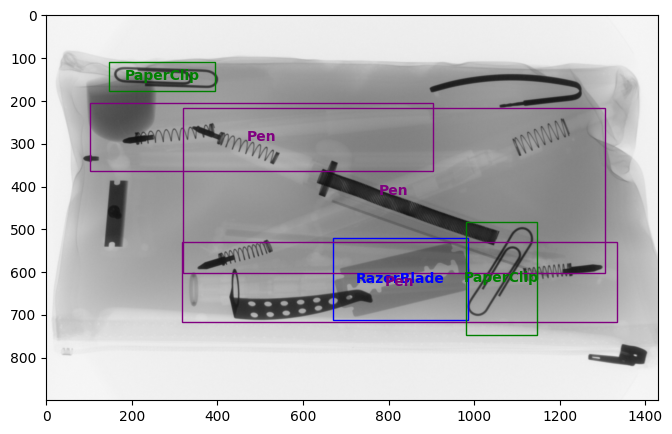

In [ ]:
'''Plot rotate image and its box to check if it is correct'''
# Set the path of the image folder
img_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/images"
# Set the path of the image folder
image_name = 'rotated_B0002_0001_90'
image_ext = '.png'
# Read the image from the given path and name
image = cv2.imread(img_folder_path + "/" + image_name + image_ext)
# Set the figure size of the plot and display the image
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image)
# Set the path of the folder containing the bounding box labels for the image
box_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/labels"
# Get the height and width of the image
height, width,_ = image.shape
# Open the file containing the bounding box labels
f = open(box_folder_path+"/"+image_name + '.txt', 'r')
# Read the lines of the file
box_list = f.readlines()
# Call the plot_box() function to plot the bounding boxes on the image
plot_box(box_list, height, width)
# Return the list of bounding boxes
box_list